In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import requests
import urllib.parse

/Users/jphoffmann/Desktop/Studium/DOPP/DOPP_GROUP25/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Analysis if travel times in europe

## Table of Contents
* [Introduction](#Introduction)
    * [Why is this topic important?](#Why-is-this-topic-important)
    * [Questions](#Questions)
* [Data gathering](#Data)
    * [Data sources](#Data-Sources)
    * [Car travel data](#Car-travel-data)
    * [Train travel data](#Train-travel-data)
        * [Duration estimation](#Train-Duration-Estimation)
    * [Air travel data](#Air-travel-data)
        * [Duration estimations](#Air-Duration-Estimation)
* [Data cleaning](#Data cleaning)
* [Analysis](#Analysis)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)
## Introduction
This notebook contains the analysis of travel data inside europe between cities with or that are close to major airports. 
### Why is this topic important
Analyzing travel times in Europe holds significance in optimizing the overall travel experience, ensuring efficiency, and promoting accessibility to diverse destinations. This analysis informs strategic infrastructure development, enabling authorities to address bottlenecks and prioritize key projects for economic growth. Efficient travel times contribute to sustainability, reducing fuel consumption and emissions, while also influencing urban planning for more livable cities. By streamlining transportation, Europe can foster economic development, attract investments, and enhance the interconnectedness of its regions. In essence, the examination of travel times is pivotal for creating a well-connected, environmentally conscious, and economically vibrant European transportation landscape.

This report targets:
- Urban planers, who can use this data to help them create well connected cities which increases accessibility
- Enviromental advocates, who can use this data to promote more efficient travel options
- Travelers, who need to find the fastest way between two cities
### Questions
Based on why we think the topic is important, we have decided to answer the following questions:
- How much faster is it to travel by plane than car/train
- Are there routes on which rail leads to shorter journey times than road and air travel? 
- On which routes is the travel duration above average?
- Which is the most well-connected city in Europe in terms of minimising travel times to other cities? 

## Data
Since we were unable to find datasets which would contain all needed data, we have decided to build our own. This notebook does not contain all the code needed to gather and process data as the process takes multiple hours and also requires 2 different API keys. The code that generates the data with additional instructions is freely available on [github](https://github.com/custibor99/DOPP_GROUP25/blob/main/docs/data_docs.md). Hovwever this notebook will contain data source descriptions and simplified overview of some processing methods.
### Data Sources
The folowing data sources have been used in the project:
- [List of largest european airports](https://airmundo.com/en/blog/airport-codes-european-airports/) according to AirMundo travel agency.
- [Pythons countryinfo package](https://github.com/porimol/countryinfo) for getting neighborings of european countries.
- [Chronotrains API](https://www.chronotrains.com/en) was used for obtaining train travel times between different cities
- [Google Maps Geocode API](https://developers.google.com/maps/documentation/geocoding/overview) were used for obtaining latitude and longitude coordinates of cities
- [Google maps distance matrix api](https://developers.google.com/maps/documentation/distance-matrix/overview) used for obtaining driving distances and durations between cities.
- Airlabs [Airports](https://airlabs.co/docs/airports) and [Schedules](https://airlabs.co/docs/schedules) API used for getting airport coordinates and snapshots of flight schedules.

### Car travel data
Car travel data has been obtained using googles [Google Maps Geocode API](https://developers.google.com/maps/documentation/geocoding/overview) and [Google maps distance matrix api](https://developers.google.com/maps/documentation/distance-matrix/overview). Below is a sample code whic display how the request can be made in python.
```python
city = "LJUBLJANA"
key = "KEY"
url = f"https://maps.googleapis.com/maps/api/geocode/json?address={city}&key={key}"
url_parsed = urllib.parse.quote(url, safe="://=?&")
response = requests.get(url_parsed)
```
The response is a json object containing data about city coordinates.
### Train travel data 
The train travel data was obtained using the [Chronotrains API](https://www.chronotrains.com/en). The website uses estimations from Deutsche Bahn. There are 2 available endpoints which can be used without an API key. Their usage is shown below.


In [7]:
url = f"https://www.chronotrains.com/api/search/Ljubljana"
url_parsed = urllib.parse.quote(url, safe="://")
response = requests.get(url_parsed)
response.json()[0]

{'name': 'Ljubljana',
 'aliases': [3196359],
 'i18nNames': {'cs': 'Lublaň',
  'da': 'Ljubljana',
  'de': 'Laibach',
  'en': 'Ljubljana',
  'es': 'Liubliana',
  'fr': 'Ljubljana',
  'it': 'Lubiana',
  'nb': 'Ljubljana',
  'nl': 'Ljubljana',
  'pl': 'Lublana',
  'ro': 'Ljubljana',
  'sv': 'Ljubljana'},
 'countryCode': 'SI'}

The aliases object represents the ID of the train station that can be used to find distances between stations.

In [8]:
url = f"https://www.chronotrains.com/api/trip/3196359/724443"
url_parsed = urllib.parse.quote(url, safe="://")
response = requests.get(url_parsed)
response.json()["suggestion"]

{'originId': 3196359,
 'destinationId': 724443,
 'duration': 681,
 'changes': 2,
 'estimatedPrice': None,
 'estimatedPriceCurrency': None,
 'journey': [3196359, 7900279, 5500008, 724443],
 'geom': 'gjaxGa`pwAkPi}C~fAdwAhvJwqJoq@g}C~{@p\\dqG_wRycC_wGxeCctFg|@syVpb@oyHtjE}lEzKe`Fw~Hg`J{{AadYguAyAkmD{|Nit@fwCsqClO{h@tdKebE`wDwrCskGipDboCor@crFgcJ_DejEghFvyBop_@{fHrXwM{yGobD}zCmdBgrK}sIkVs~FyjSrCyi_@ynD_|HnwD_zt@mvCm}@g_MjwDw}A}kIq|Ef~EihO}cGogChsF{tIjxBc}OwxAaqAscB{{Aet[??e`Dsts@}{DoxV||DcpYctFgkFwWccFqeG__IchHetEcv@qlLusG}qTgyF}Cs`Hr|Cq_I{uBleEyqN|tB{c[bfF}~Mn@ciEmgN_r[rbCol@oe@gfJp|BgqKawAgsNrgC_`Csq@upL{{GinWlU_fEw`EupEprCydJsYsiaAgqJ_{WkhPa|SgvHqkTodFyzY_`IdkB??s_Dkb[oaBnp@{nAcmJajFqtJm`GxPlTuwVo`EkeCitCokKtsCgkXa`EeeKa|B}x@x_AsoImlC}yh@}vE}mUquFapnAg_\\{f`Ae_DamCydKszAw{Qp{FdjAecOw|T{aIq~Xyzb@qz_@}uRokQcnPi~V~bI'}

#### Train Duration Estimation 
The provided estimations were mostly reasonable when you were traveling inside a country and between neighboring countries, but if we wanted to receive an estimate for a long route that would travel between multiple countries the API did not produce any results. This is why we have decided to estimate the train travel durations. The idea of the algorithms is that we get the travel times between cities in the same country and neighboring countries and connect them in a graph. Afterwards we can use a shortest path algorithm to estimate the duration of any path as long as their exist a connection in the graph. The graph creation pseudo code is provided below
```
Create an empty graph G
Add all cities to G as nodes
For each city in a country:
		get the travel duration to all other cities in the country
        add the travel durations to the graph

		get the travel durations to all cities from neighboring countries
		add the travel durations to the graph
```

### Air travel data
Our network of airports was built from the [list of largest european airports](https://airmundo.com/en/blog/airport-codes-european-airports/) according to AirMundo travel agency. Just like the above graph for train stations, they represent nodes connected by edges containing the distance between them.

Airport coordinates were taken from the [Airlabs Airports API](https://airlabs.co/docs/airports) by querying the iata-codes from the above mentioned list of airports.



### Air Duration Estimation
Only [one source (OpenFlights)](https://github.com/jpatokal/openflights/tree/master/data) provided free records of flight data, but it was outdated by about 8 years and was missing many flight routes. Our first approach was therefore calculating the duration using distance and average flight speed. Short comparisons with real world data showed that we could not get accurate enough results with this approach.

We tried web scraping data from sites like [FlightAware](https://de.flightaware.com/) or [Flightradar24](https://www.flightradar24.com/43.12,16.87/6). FlightAware would have provided flight codes by searching through all pairs of iata codes. Flightradar24 would provide flight history, as well as average durations for each flight code. However, this would have taken too many processing hours for our task (up to several days).

We finally opted for creating a regression model to estimate flight duration based on travel distance. The [Airlabs Schedules API](https://airlabs.co/docs/schedules) provides live schedule data, which contains estimated flight durations, as well as real flight durations for flights that have already concluded.

In [3]:
airport_data = pd.read_csv("../data/clean/airport_data.csv")
airport_network = nx.read_gml("../data/airport_network.gml")
schedules = pd.read_csv("../data/airport_schedules.csv")

# Only consider schedules that are within our european airport network
schedules = schedules[schedules["arr_iata"].isin(airport_data["iata_code"])]
display(schedules)

,airline_iata,airline_icao,flight_iata,flight_icao,flight_number,dep_iata,dep_icao,dep_terminal,dep_gate,dep_time,...,arr_delayed,aircraft_icao,arr_time_ts,dep_time_ts,arr_estimated_ts,dep_estimated_ts,dep_actual_ts,arr_actual,arr_actual_utc,arr_actual_ts
0,W9,WUK,W94466,WUK4466,4466,TIA,LATI,NaN,NaN,2024-01-04 12:25,...,NaN,NaN,1704380100,1704367500,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
1,W4,WMT,W46633,WMT6633,6633,TIA,LATI,NaN,NaN,2024-01-04 12:30,...,9.0,NaN,1704378600,1704367800,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
2,ZB,ABN,ZB2011,ABN2011,2011,TIA,LATI,NaN,NaN,2024-01-04 12:40,...,NaN,A319,1704375600,1704368400,NaN,NaN,NaN,NaN,NaN,NaN
3,2B,AWT,2B233,AWT233,233,TIA,LATI,NaN,NaN,2024-01-04 12:00,...,NaN,B734,1704372600,1704366000,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
4,W4,WMT,W46673,WMT6673,6673,TIA,LATI,NaN,NaN,2024-01-04 12:55,...,NaN,NaN,1704375000,1704369300,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22960,BA,BAW,BA4064,BAW4064,4064,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,NaN,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22962,LM,LOG,LM490,LOG490,490,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,E145,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22963,EI,EIN,EI3309,EIN3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN
22964,EA,EAI,EA3309,EAI3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN


Removing all flights that haven't landed yet (arr_actual being NaN) left us with only 344 entries. We therefore chose to use the estimated time from the "duration" column to be able to use all ~5500 data points. We also remove alot of duplicate entries, as well as obvious outliers (over 16 hours travel time for distances under 100km).


In [33]:
schedules = schedules[["dep_iata", "arr_iata", "duration"]]
schedules.dropna(inplace=True)
schedules.drop_duplicates(inplace=True)
schedules.reset_index(drop=True, inplace=True)

# Remove outliers
schedules = schedules[~(schedules["duration"] > 1000)]

# Get distances from airport network 
for i, (dep, arr) in schedules[["dep_iata", "arr_iata"]].iterrows():
    if airport_network.has_edge(dep, arr):
        schedules.at[i, "distance"] = airport_network.edges[dep, arr]["distance"]

schedules = schedules[~(schedules["distance"] > 6000000)]
display(schedules.head())

,dep_iata,arr_iata,duration,distance
0,TIA,LTN,210,1912943.0
1,TIA,BVA,180,1631963.0
2,TIA,VRN,120,837947.0
3,TIA,BGY,110,933984.0
4,TIA,CIY,95,659725.0


### Linear Regression
Experimentation with a naive linear model shows a slight curve in the relationship between distance and duration .

In [34]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration"].values.reshape(-1, 1)
model.fit(X, y)

LinearRegression()

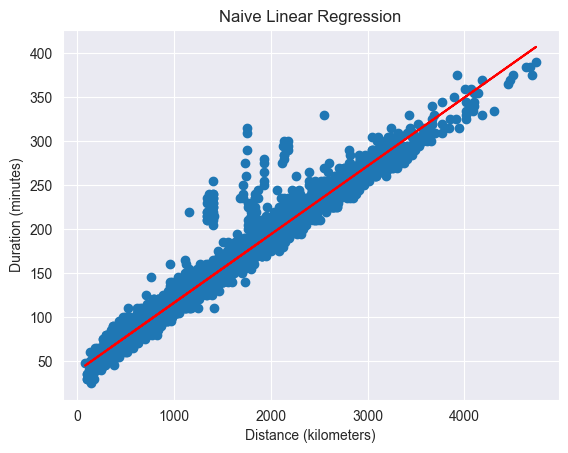

In [35]:
# plotting the model
fig = plt.figure()
ax = fig.add_subplot()

m2km = lambda x, _: f'{x/1000:g}'
ax.xaxis.set_major_formatter(m2km)

ax.scatter(schedules["distance"], schedules["duration"], )
ax.plot(X, model.predict(X), color="red")
plt.title("Naive Linear Regression")
plt.xlabel("Distance (kilometers)")
plt.ylabel("Duration (minutes)")
plt.show()

### Linear Regression with basis expansion
We chose Linear Regression with basis expansion, to fit this curve.

In [36]:
from sklearn.preprocessing import PolynomialFeatures

X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration"].values.reshape(-1, 1)

degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

model_be = LinearRegression()
model_be.fit(X_poly, y)

LinearRegression()

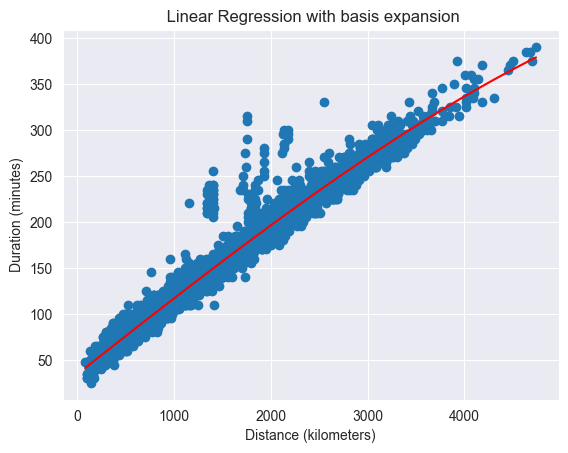

In [37]:
fig = plt.figure()
ax = fig.add_subplot()

m2km = lambda x, _: f'{x/1000:g}'
ax.xaxis.set_major_formatter(m2km)

X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly_features.transform(X_sorted)

ax.scatter(schedules["distance"], schedules["duration"])
ax.plot(X_sorted, model_be.predict(X_sorted_poly), color='red')
plt.title(" Linear Regression with basis expansion")
plt.xlabel("Distance (kilometers)")
plt.ylabel("Duration (minutes)")
plt.show()

### Calculating the Root-mean-square deviation
Comparing both models we can see that the second approach is better suited for the data.

In [38]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

print("RMSE:")
print("Naive: ", calculate_rmse(y, model.predict(X)))
print("Basis expansion: ", calculate_rmse(y, model_be.predict(X_poly)))

RMSE:
Naive:  12.102402020483817
Basis expansion:  11.903377264159404


## Data cleaning
joined all graphs/files
joined overlapping airports/trainstations 
dropped trainstations that were assigned to the wrong city (chronotrains api was faulty)
dropped island cities

## Analysis